# AI for Waste Management

Firstly, we install the necessary API for downloading data directly from Kaggle.

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d asdasdasasdas/garbage-classification

In [ ]:
!unzip garbage-classification.zip

Importing all necessary libraries and frameworks.

In [257]:
import torch
from torch import nn, optim
from torchvision import models, datasets, transforms

import numpy as np
import os
import time
import copy
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

In [116]:
BATCH_SIZE = 64
EPOCHS = 10
NUM_CLASSES = 6
use_pretrained = True
MODEL_NAME = 'resnet152'

In [117]:
data_dir = './garbage classification/Garbage classification'

classes = os.listdir(data_dir)
classes

['trash', 'paper', 'cardboard', 'plastic', 'glass', 'metal']

# Utility Methods

In [118]:
def set_parameters_requires_grad(model):
  for param in model.parameters():
    param.requires_grad = False

In [227]:
def initialize_model(model_name, num_classes, use_pretrained=True):
  model = None
  input_size=0

  if model_name == "resnet18":
    model = models.resnet18(pretrained=use_pretrained)
  elif model_name == "resnet34":
    model = models.resnet34(pretrained=use_pretrained)
  elif model_name == "resnet50":
    model = models.resnet50(pretrained=use_pretrained)
  elif model_name == "resnet101":
    model = models.resnet101(pretrained=use_pretrained)
  elif model_name == "resnet152":
    model = models.resnet152 (pretrained=use_pretrained)
  

  set_parameters_requires_grad(model)
  num_in_ftrs = model.fc.in_features
  model.fc = nn.Sequential(
    nn.Linear(num_in_ftrs, num_classes),)
    #nn.Softmax(dim=1))
  input_size = 224

  return model, input_size

In [220]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('=' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}\n'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, val_acc_history

# Data Operations

Loading data from images, splitting into train-val-test sets etc.

In [121]:
data_transforms = {
    "train" : transforms.Compose([transforms.RandomRotation(45),
                                transforms.CenterCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),
    "val" : transforms.Compose([transforms.Resize(255),
                              transforms.CenterCrop(224),
                              transforms.ToTensor(),
                              transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),
    "test" : transforms.Compose([transforms.Resize(255),
                              transforms.CenterCrop(224),
                              transforms.ToTensor(),
                              transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
}

In [122]:
data = datasets.ImageFolder(data_dir, transform=test_transforms)
train_ds, val_ds, test_ds = torch.utils.data.random_split(data, [1593, 176, 758])

In [123]:
image_datasets = {'train': train_ds, 'val':val_ds, 'test':test_ds}

dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Example image:

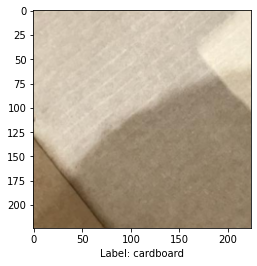

In [124]:
img, lbl = data[345]
plt.imshow(img.permute(1, 2, 0))
plt.xlabel(f"Label: {data.classes[lbl]}")
plt.show()

In [232]:
model, input_size = initialize_model("resnet152", num_classes=NUM_CLASSES)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


In [233]:
model = model.to(device)

print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
  if param.requires_grad == True:
      params_to_update.append(param)
      print("\t",name)

Params to learn:
	 fc.0.weight
	 fc.0.bias


In [235]:
optimizer = optim.Adam(params_to_update, lr=3e-04)

criterion = nn.CrossEntropyLoss()

best_model, history = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=EPOCHS+5)

Epoch 0/14
train Loss: 1.5566 Acc: 0.4225

val Loss: 1.2681 Acc: 0.6761

Epoch 1/14
train Loss: 1.1729 Acc: 0.6849

val Loss: 1.0019 Acc: 0.7841

Epoch 2/14
train Loss: 0.9611 Acc: 0.7382

val Loss: 0.8496 Acc: 0.8068

Epoch 3/14
train Loss: 0.8352 Acc: 0.7633

val Loss: 0.7470 Acc: 0.7955

Epoch 4/14
train Loss: 0.7486 Acc: 0.7841

val Loss: 0.6730 Acc: 0.8182

Epoch 5/14
train Loss: 0.6892 Acc: 0.8035

val Loss: 0.6309 Acc: 0.8239

Epoch 6/14
train Loss: 0.6463 Acc: 0.8041

val Loss: 0.6072 Acc: 0.8295

Epoch 7/14
train Loss: 0.6150 Acc: 0.8305

val Loss: 0.5807 Acc: 0.8295

Epoch 8/14
train Loss: 0.5773 Acc: 0.8274

val Loss: 0.5572 Acc: 0.8239

Epoch 9/14
train Loss: 0.5535 Acc: 0.8362

val Loss: 0.5468 Acc: 0.8523

Epoch 10/14
train Loss: 0.5350 Acc: 0.8412

val Loss: 0.5238 Acc: 0.8580

Epoch 11/14
train Loss: 0.5027 Acc: 0.8500

val Loss: 0.4996 Acc: 0.8693

Epoch 12/14
train Loss: 0.5042 Acc: 0.8481

val Loss: 0.4911 Acc: 0.8409

Epoch 13/14
train Loss: 0.4781 Acc: 0.8682

val 

# Prediction Example

In [251]:
img, lbl = image_datasets['test'][-17]

y_hat = nn.Softmax(dim=1)(best_model(img.unsqueeze(0).to(device)))
prob, preds  = torch.max(y_hat, dim=1)

In [252]:
prob[0].item()

0.9054626226425171

In [253]:
preds

tensor([1], device='cuda:0')

In [254]:
data.classes[preds[0].item()]

'glass'

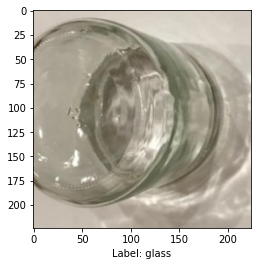

In [255]:
plt.imshow(img.permute(1, 2, 0))
plt.xlabel(f"Label: {data.classes[lbl]}")
plt.show()

## Saving the best model

In [256]:
PATH = "resnet_model.pt"

torch.save(best_model, PATH)